In [16]:
from qiskit import *
from qiskit_aer import AerSimulator
import numpy as np

#### Função de Tomografia

In [17]:
import numpy as np
from qiskit import *
from qiskit_aer import AerSimulator

pauli_list = [
    np.eye(2),
    np.array([[0.0, 1.0], [1.0, 0.0]]),
    np.array([[0, -1.0j], [1.0j, 0.0]]),
    np.array([[1.0, 0.0], [0.0, -1.0]]),
]

bases = {
    'I': pauli_list[0],
    'X': pauli_list[1],
    'Y': pauli_list[2],
    'Z': pauli_list[3],
}

backend = AerSimulator()

def measurement_circuit(base,input_circuit, target):
    circuit = input_circuit.copy()

    if base == 'X':
        circuit.h(target)
    elif base == 'Y':
        circuit.sdg(target)
        circuit.h(target)

    creg = ClassicalRegister(1, 'c_tom')
    circuit.add_register(creg)
    circuit.measure(target,creg[0])

    return circuit

def tomography(my_circuit, target,shots):
    expectation_values = {}
    all_counts = {}

    for base in ['X','Y','Z']:
        circ       = measurement_circuit(base, my_circuit, target)
        transpiled = transpile(circ, backend)
        result     = backend.run(transpiled, shots=shots).result()
        counts     = result.get_counts()

        # Agora filtramos o primeiro bit da string (bits[0]), que corresponde a c_tom[0]
        p0 = sum(cnt for bits, cnt in counts.items() if bits[0]=='0')
        p1 = sum(cnt for bits, cnt in counts.items() if bits[0]=='1')
        total = p0 + p1 or 1

        expectation_values[base] = (p0 - p1) / total
        all_counts[base] = counts

    rho = 0.5 * (
        pauli_list[0]
        + expectation_values['X'] * pauli_list[1]
        + expectation_values['Y'] * pauli_list[2]
        + expectation_values['Z'] * pauli_list[3]
    )

    return rho, expectation_values



#### Algoritmo para Tomografia

In [18]:
def function_tel(n=0):
    Alice = QuantumRegister(1,'Alice')
    Bob = QuantumRegister(1,'Bob')
    Secret = QuantumRegister(1,'Secret')
    classical = ClassicalRegister(2, 'c')

    circuit = QuantumCircuit(Secret,Alice,Bob,classical)

    # Se n>0, adiciona registrador extra "ext" com n qubits
    if n > 0:
        ext = QuantumRegister(n, 'ext')
        circuit = QuantumCircuit(Secret, Alice, Bob, ext, classical)
    else:
        circuit = QuantumCircuit(Secret, Alice, Bob, classical)
    
    #EPR
    circuit.h(Alice)
    circuit.cx(Alice,Bob)
    circuit.barrier()

    # swaps
    if n > 0:
        circuit.swap(Bob[0], ext[0])
        for i in range(1, n):
            circuit.swap(ext[i - 1], ext[i])
        final_target = ext[n - 1]
    else:
        final_target = Bob[0]


    #Passa a informação
    circuit.barrier()
    circuit.h(Secret)
    circuit.barrier()

    #Misturas de Estados
    circuit.cx(Secret,Alice)
    circuit.h(Secret)
    circuit.barrier()

    #Medições
    circuit.measure(Alice, classical[1])
    circuit.measure(Secret, classical[0])
    circuit.barrier()

    # Correções condicionais usando if_test()
    with circuit.if_test((classical, 1)):
        circuit.x(final_target)

    with circuit.if_test((classical, 2)):
        circuit.z(final_target)


    return circuit

In [19]:
circuit = function_tel(n=0)
circuit_2 = function_tel(n=2)
circuit_4 = function_tel(n=4)
circuit_6 = function_tel(n=6)
circuit_8= function_tel(n=8)

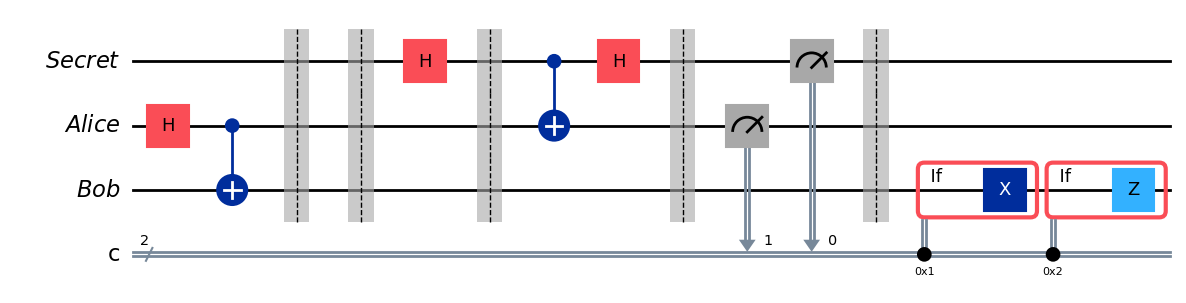

In [20]:
circuit.draw('mpl')

In [21]:
rho = tomography(circuit,target=2,shots=10000)
rho_2 = tomography(circuit_2,target=4,shots=10000)
rho_4 = tomography(circuit_4,target=6,shots=10000)
rho_6 = tomography(circuit_6,target=8,shots=10000)
rho_8 = tomography(circuit_8,target=10,shots=10000)

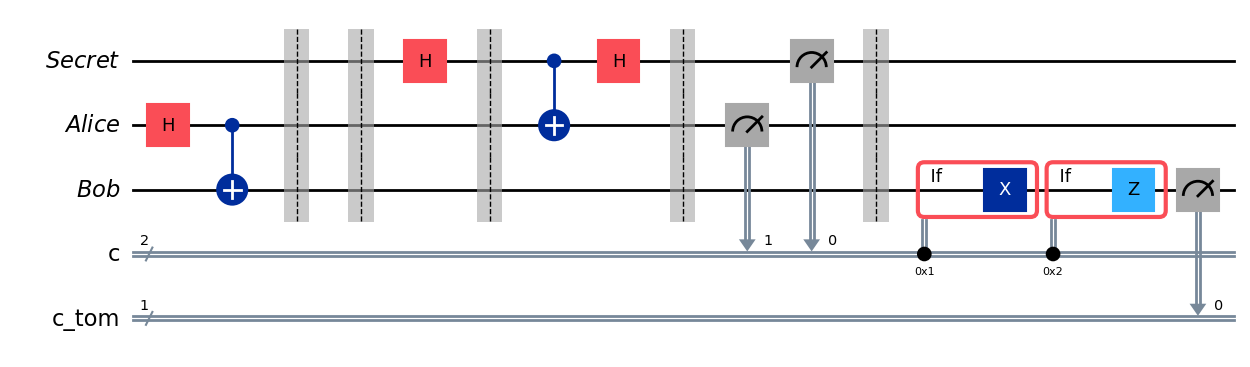

In [22]:
circuit_measure = measurement_circuit(base=['X','Y','Z'],input_circuit=circuit,target=2)
circuit_measure.draw('mpl')